In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl, pandas as pd, numpy as np, geopandas as gpd, pingouin as pin, matplotlib.pyplot as plt

import pysal as ps
from math import sqrt
import pylab
import ast
import networkx as nx

pd.set_option('precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

In [2]:
import cityImage as ci
import ABManalysis as af

## 0.0 Loading Shapefile

In [3]:
# initialise path, names, etc.
city_name = 'Paris'
epsg = 27571
crs = {'init': 'epsg:'+str(epsg), 'no_defs': True}

In [4]:
input_path = 'Input/regionBasedNavigation/'+city_name
output_path = 'Outputs/regionBasedNavigation/'+city_name

edges = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
nodes = gpd.read_file(input_path+'_nodes.shp', driver='ESRI Shapefile')

nodes.index, edges.index = nodes.nodeID, edges.edgeID
nodes.index.name, edges.index.name = None, None

## 0.1 Loading  the simulation's volumes

In [5]:
columns = ['edgeID', 'AC', 'RB', 'BB','RBB']

runs = 5
df_list = []
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_districts_'+str(run)+'.csv')
    df_tmp = df_tmp[columns]
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID0
for run in range(runs): 
    df.drop(['edgeID'+str(run)], axis = 1, inplace = True)

df_list = []
route_choice_models = ['AC', 'RB', 'BB','RBB']
for model in route_choice_models: 
    if model == 'RBB': 
        df_list.append(df[[col for col in df if col.startswith(model)]+['edgeID']])
    # 'RB' and 'RBB' same starting string
    else: 
        df_list.append(df[[col for col in df if (col.startswith(model) and not col.startswith('RBB'))]+['edgeID']])
    
# aggregate runs values
edges = af.aggregate_runs(df_list, route_choice_models, edges, ddof = 0)

## 0.2 Loading the simulation's resulting routes

In [6]:
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
input_path_routes = 'Input/regionBasedNavigation/routes/'+city_name
routes_gdfs = []

for run in range(runs):
    run_gdf = gpd.read_file(input_path_routes+'_PedSim_district_routes_'+str(run)+'.shp')

    for n, model in enumerate(route_choice_models):
        model_gdf = run_gdf[run_gdf.routeChoic == model].copy()
        if run == 0:
            routes_gdf = model_gdf.copy()
            routes_gdfs.append(model_gdf)
            continue
        routes_gdf = routes_gdfs[n].copy()
        routes_gdf = routes_gdf.append(model_gdf)
        routes_gdf.reset_index(inplace = True, drop=True)
        routes_gdf = routes_gdf.where(pd.notnull(routes_gdf), None)
        routes_gdfs[n] = routes_gdf

In [7]:
# preparing the routes gdf
for n, model in enumerate(route_choice_models): 
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdf['O'] = routes_gdf['O'].astype(int)
    routes_gdf['D'] = routes_gdf['D'].astype(int)
    routes_gdfs[n] = routes_gdf

## 1 Computing statistics of each route
### 1.1 Distance walked along: pedestrian roads, major roads, positive barriers

In [8]:
edges['length'] = edges.geometry.length
col = ['ped', 'maj', 'bar'] 
if 'p_bool' not in edges.columns:
    edges['p_barr'] = [ast.literal_eval(i) for i in edges['p_barr']]
    edges['p_bool'] = edges.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)

for n, model in enumerate(route_choice_models):
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf = routes_gdf.assign(**dict.fromkeys(col, 0.0))
    routes_gdf['districts'] = None
    routes_gdf[['ped', 'maj', 'bar', 'districts']] = routes_gdf.apply(lambda row: af.regionBased_variables(row['edgeIDs'],
                                           row['geometry'], nodes,  edges), axis = 1, result_type='expand')
    routes_gdf['nr_dis'] = routes_gdf.apply(lambda row: af.count_regions(row, nodes), axis = 1)
    routes_gdfs[n] = routes_gdf

### 1.2 Deviation from the road-distance shortest path

In [6]:
graph = ci.graph_fromGDF(nodes, edges, nodeID = "nodeID")
distances = {}
routes_gdf = routes_gdfs[0].copy()
for row in routes_gdf.itertuples():
    source = routes_gdf.loc[row[0]]['O']
    target = routes_gdf.loc[row[0]]['D']
    distance  = nx.shortest_path_length(graph, source=source, target=target, weight='length', method='dijkstra')
    distances[str(source)+"-"+str(target)] = distance

## 2 Getting the statistics
### 2.1 Deviation from the road-distance shortest path

In [7]:
for n, model in enumerate(route_choice_models):
    print(model)
    routes_gdf = routes_gdfs[n].copy()
    print("median routes' lenght:", routes_gdf.geometry.length.median())
    routes_gdf['sp_dist'] = routes_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
    routes_gdf['sp_dev'] = routes_gdf.geometry.length/routes_gdf['sp_dist']
    print("median routes' deviation from SP", routes_gdf['sp_dev'].median())
    print()
    routes_gdfs[n] = routes_gdf

AC
median routes' lenght: 2899.786435234929
median routes' deviation from SP 1.1288684849040216

RB
median routes' lenght: 2988.5080124358146
median routes' deviation from SP 1.1603613139138735

BB
median routes' lenght: 3718.2679349242208
median routes' deviation from SP 1.47914478104651

RBB
median routes' lenght: 3425.980265613898
median routes' deviation from SP 1.3344062365908123



### 2.2 Deviation per scenario vs the nr of districts traversed

In [8]:
for n, model in enumerate(route_choice_models):
    print(model)
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['nr_dis'] = np.where(routes_gdf['nr_dis']<=5, routes_gdf['nr_dis'], 5)
    print('1 district', routes_gdf[routes_gdf['nr_dis'] == 1]['sp_dev'].median())
    print('2 district', routes_gdf[routes_gdf['nr_dis'] == 2]['sp_dev'].median())
    print('3 district', routes_gdf[routes_gdf['nr_dis'] == 3]['sp_dev'].median())
    print('4 district', routes_gdf[routes_gdf['nr_dis'] == 4]['sp_dev'].median())
    print('5 district', routes_gdf[routes_gdf['nr_dis'] == 5]['sp_dev'].median())
    print( )
print()

AC
1 district 1.1017831308929278
2 district 1.1106479980481936
3 district 1.149191064446908
4 district 1.2030202184275813
5 district 1.3535017415359265

RB
1 district 1.10623673501311
2 district 1.1489751821699141
3 district 1.1995039878695042
4 district 1.2826934873462292
5 district 1.9471111218848536

BB
1 district 1.2782787623313034
2 district 1.3810243674221157
3 district 1.5212959442981555
4 district 1.669184404237741
5 district 1.9947108096429562

RBB
1 district 1.2870537209127069
2 district 1.311959778070999
3 district 1.367771999546565
4 district 1.504095372979231
5 district 2.32902005190542




### 2.3 Deviation per scenario vs routes' length

In [9]:
for n, model in enumerate(route_choice_models):
    print(model)
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['length'] = routes_gdf.geometry.length
    print('correlation length and deviation :', np.corrcoef(routes_gdf['length'], routes_gdf['sp_dev'])[0][1])
    print('routes similar to shortest path', len(routes_gdf[routes_gdf['sp_dev'] < 1.10])/len(routes_gdf)*100,'%')
    print()
print()

AC
correlation length and deviation : 0.48318590644057074
routes similar to shortest path 41.54 %

RB
correlation length and deviation : 0.5789524148694325
routes similar to shortest path 34.160000000000004 %

BB
correlation length and deviation : 0.7483040160468545
routes similar to shortest path 10.57 %

RBB
correlation length and deviation : 0.6778503685985302
routes similar to shortest path 14.67 %




### *Saving and Loading*

In [10]:
# export routes
for n, model in enumerate(route_choice_models):
    routes_gdfs[n]['ds_str'] = routes_gdfs[n]['districts'].astype(str)
    routes_gdfs[n].drop(['districts', 'edgeIDs'], axis = 1, errors = 'ignore').to_file(
        output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')

In [5]:
## reload routes
routes_gdfs = []
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
for n, model in enumerate(route_choice_models):
    routes_gdf = gpd.read_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')
    routes_gdf['districts'] = [ast.literal_eval(i) for i in routes_gdf['ds_str']]
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdfs.append(routes_gdf)

### 2.4 Significance test on road types portions
* Meters traversed along pedestrian roads
* Meters traversed along major roads
* Meters traversed along barriers

In [15]:
labels = ['ped', 'maj', 'bar'] 
titles = ['Pedestrian Roads', 'Major Roads', 'Natural Barriers']
routes_stats = af.generate_routes_stats(routes_gdfs, route_choice_models, labels, titles)  

In [16]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Pedestrian Roads'], dv= 'values', 
                         between = 'routeChoice', tail = 'two sided', effsize = 'cohen', alpha = 0.01)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,cohen
0,AC,BB,0.12,0.13,-0.01,0.00,two sided,-6.91,19943.69,0.00,-0.10
1,AC,RB,0.12,0.14,-0.02,0.00,two sided,-10.09,19993.07,0.00,-0.14
2,AC,RBB,0.12,0.14,-0.02,0.00,two sided,-8.45,19962.32,0.00,-0.12
3,BB,RB,0.13,0.14,-0.01,0.00,two sided,-3.38,19971.37,0.00,-0.05
4,BB,RBB,0.13,0.14,-0.00,0.00,two sided,-1.61,19996.03,0.37,-0.02
5,RB,RBB,0.14,0.14,0.00,0.00,two sided,1.78,19983.86,0.28,0.03


In [17]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Major Roads'], dv= 'values', between = 'routeChoice', 
                        tail = 'two sided', effsize = 'hedges', alpha = 0.01)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,AC,BB,0.14,0.17,-0.02,0.00,two sided,-9.52,19372.41,0.00,-0.14
1,AC,RB,0.14,0.11,0.03,0.00,two sided,14.10,18928.43,0.00,0.20
2,AC,RBB,0.14,0.12,0.02,0.00,two sided,9.22,18131.51,0.00,0.13
3,BB,RB,0.17,0.11,0.06,0.00,two sided,26.47,19924.84,0.00,0.37
4,BB,RBB,0.17,0.12,0.04,0.00,two sided,21.59,19559.21,0.00,0.30
5,RB,RBB,0.11,0.12,-0.01,0.00,two sided,-6.18,19837.32,0.00,-0.09


In [18]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Natural Barriers'], dv= 'values', between = 'routeChoice', 
                        tail = 'two sided', effsize = 'hedges',  alpha = 0.01)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,AC,BB,0.09,0.13,-0.04,0.00,two sided,-17.95,19843.34,0.00,-0.25
1,AC,RB,0.09,0.09,-0.01,0.00,two sided,-3.68,19905.92,0.00,-0.05
2,AC,RBB,0.09,0.11,-0.03,0.00,two sided,-12.54,19991.31,0.00,-0.18
3,BB,RB,0.13,0.09,0.04,0.00,two sided,14.99,19526.65,0.00,0.21
4,BB,RBB,0.13,0.11,0.01,0.00,two sided,5.81,19900.19,0.00,0.08
5,RB,RBB,0.09,0.11,-0.02,0.00,two sided,-9.31,19850.51,0.00,-0.13


## 2. Volumes

### Saving volumes

In [21]:
edges.drop('p_barr', axis = 1).to_file(output_path+'_pedSim_RB.shp',  use_unicode=True, driver='ESRI Shapefile')

### 2.1 Statistics and scenarios' comparison 

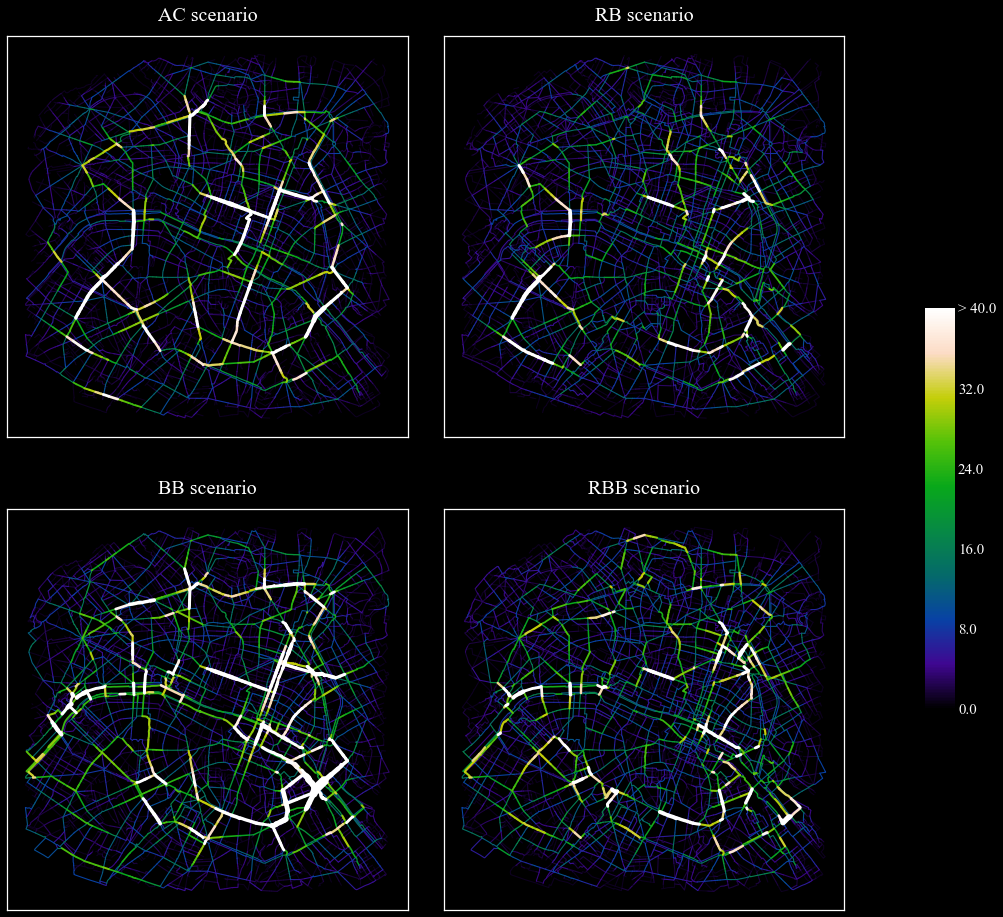

In [23]:
subtitles = ['AC scenario', 'RB scenario', 'BB scenario', 'RBB scenario']

norm = mpl.colors.Normalize(vmin=0, vmax= 40)
fig = ci.plot_gdf_grid(edges, columns = route_choice_models, cmap = ci.kindlmann(), norm = norm, titles = subtitles, cbar = True, cbar_ticks = 5,
        cbar_max_symbol = True, lw_factor = 0.07, axis_frame = True, black_background = True)

In [27]:
fig.savefig("Outputs/Figures/regionBasedNavigation/Fig8.pdf", bbox_inches='tight')

In [29]:
titles =['Angular change scenario','Region-based scenario',  'Barrier-based scenario', 'Region-Barrier based scenario']
num_trips = 2000

for n, model in enumerate(route_choice_models):
    print(titles[n]+' mean is ', edges[model].mean())
    print(titles[n]+' STD is ', edges[model].std())
    print(titles[n]+' max is ', edges[model].max())
    print()

Angular change scenario mean is  4.844099574602175
Angular change scenario STD is  8.286898785919563
Angular change scenario max is  70.0

Region-based scenario mean is  5.215850007877737
Region-based scenario STD is  7.429420898377277
Region-based scenario max is  66.0

Barrier-based scenario mean is  6.315582164802269
Barrier-based scenario STD is  9.831407064418027
Barrier-based scenario max is  130.0

Region-Barrier based scenario mean is  5.885300141799275
Region-Barrier based scenario STD is  8.024047000191523
Region-Barrier based scenario max is  77.0



### 2.2 Inequality - Gini Coefficient

In [31]:
sgs = []
for n, model in enumerate(route_choice_models):
    sg = ps.explore.inequality.gini.Gini(list(edges[model]))
    print(model, sg.g)

AC 0.7178925673280725
RB 0.6489512805065415
BB 0.6856546350742501
RBB 0.6366561253650249
